In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report,
    roc_auc_score, roc_curve, silhouette_score
)
from sklearn.utils import resample
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from joblib import Parallel, delayed
from tqdm import tqdm

# Models
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
)
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# Additional Libraries
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Load datasets
#heart_attack_data = pd.read_csv('heart_attack_prediction_dataset.csv')
cvd_cleaned_data = pd.read_csv('CVD_cleaned.csv')


In [80]:
cvd_cleaned_data

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Poor,Within the past 2 years,No,No,No,No,No,No,Yes,Female,70-74,150.0,32.66,14.54,Yes,0.0,30.0,16.0,12.0
1,Very Good,Within the past year,No,Yes,No,No,No,Yes,No,Female,70-74,165.0,77.11,28.29,No,0.0,30.0,0.0,4.0
2,Very Good,Within the past year,Yes,No,No,No,No,Yes,No,Female,60-64,163.0,88.45,33.47,No,4.0,12.0,3.0,16.0
3,Poor,Within the past year,Yes,Yes,No,No,No,Yes,No,Male,75-79,180.0,93.44,28.73,No,0.0,30.0,30.0,8.0
4,Good,Within the past year,No,No,No,No,No,No,No,Male,80+,191.0,88.45,24.37,Yes,0.0,8.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308849,Very Good,Within the past year,Yes,No,No,No,No,No,No,Male,25-29,168.0,81.65,29.05,No,4.0,30.0,8.0,0.0
308850,Fair,Within the past 5 years,Yes,No,No,No,No,Yes,No,Male,65-69,180.0,69.85,21.48,No,8.0,15.0,60.0,4.0
308851,Very Good,5 or more years ago,Yes,No,No,No,Yes,"Yes, but female told only during pregnancy",No,Female,30-34,157.0,61.23,24.69,Yes,4.0,40.0,8.0,4.0
308852,Very Good,Within the past year,Yes,No,No,No,No,No,No,Male,65-69,183.0,79.38,23.73,No,3.0,30.0,12.0,0.0


In [81]:
cvd_cleaned_data['General_Health'].values

array(['Poor', 'Very Good', 'Very Good', ..., 'Very Good', 'Very Good',
       'Excellent'], dtype=object)

In [82]:
cvd_cleaned_data.groupby('Heart_Disease').describe().T

Heart_Disease                                  No           Yes
Height_(cm)                  count  283883.000000  24971.000000
                             mean      170.565367    171.182332
                             std        10.659193     10.628520
                             min        91.000000     91.000000
                             25%       163.000000    163.000000
                             50%       170.000000    173.000000
                             75%       178.000000    178.000000
                             max       241.000000    216.000000
Weight_(kg)                  count  283883.000000  24971.000000
                             mean       83.298262     86.889986
                             std        21.298574     21.571551
                             min        24.950000     30.000000
                             25%        68.040000     72.570000
                             50%        81.190000     83.910000
                             75%        95.250000     99.790000
                             max       293.020000    283.500000
BMI                          count  283883.000000  24971.000000
                             mean       28.543676     29.564505
                             std         6.511201      6.575148
                             min        12.020000     12.110000
                             25%        24.140000     25.090000
                             50%        27.440000     28.550000
                             75%        31.660000     32.890000
                             max        99.330000     88.570000
Alcohol_Consumption          count  283883.000000  24971.000000
                             mean        5.185298      4.085339
                             std         8.198700      8.143996
                             min         0.000000      0.000000
                             25%         0.000000      0.000000
                             50%         1.000000      0.000000
                             75%         7.000000      4.000000
                             max        30.000000     30.000000
Fruit_Consumption            count  283883.000000  24971.000000
                             mean       29.983159     28.153138
                             std        24.908340     24.439608
                             min         0.000000      0.000000
                             25%        12.000000     10.000000
                             50%        30.000000     30.000000
                             75%        30.000000     30.000000
                             max       120.000000    120.000000
Green_Vegetables_Consumption count  283883.000000  24971.000000
                             mean       15.216878     13.900404
                             std        15.003458     13.961847
                             min         0.000000      0.000000
                             25%         4.000000      4.000000
                             50%        12.000000     10.000000
                             75%        20.000000     20.000000
                             max       128.000000    124.000000
FriedPotato_Consumption      count  283883.000000  24971.000000
                             mean        6.320104      6.029594
                             std         8.589234      8.506845
                             min         0.000000      0.000000
                             25%         2.000000      1.000000
                             50%         4.000000      4.000000
                             75%         8.000000      8.000000
                             max       128.000000    120.000000

In [83]:
#heart_attack_data.groupby('Heart Attack Risk').describe().T

In [84]:
cvd_cleaned_data.columns

Index(['General_Health', 'Checkup', 'Exercise', 'Heart_Disease', 'Skin_Cancer',
       'Other_Cancer', 'Depression', 'Diabetes', 'Arthritis', 'Sex',
       'Age_Category', 'Height_(cm)', 'Weight_(kg)', 'BMI', 'Smoking_History',
       'Alcohol_Consumption', 'Fruit_Consumption',
       'Green_Vegetables_Consumption', 'FriedPotato_Consumption'],
      dtype='object')

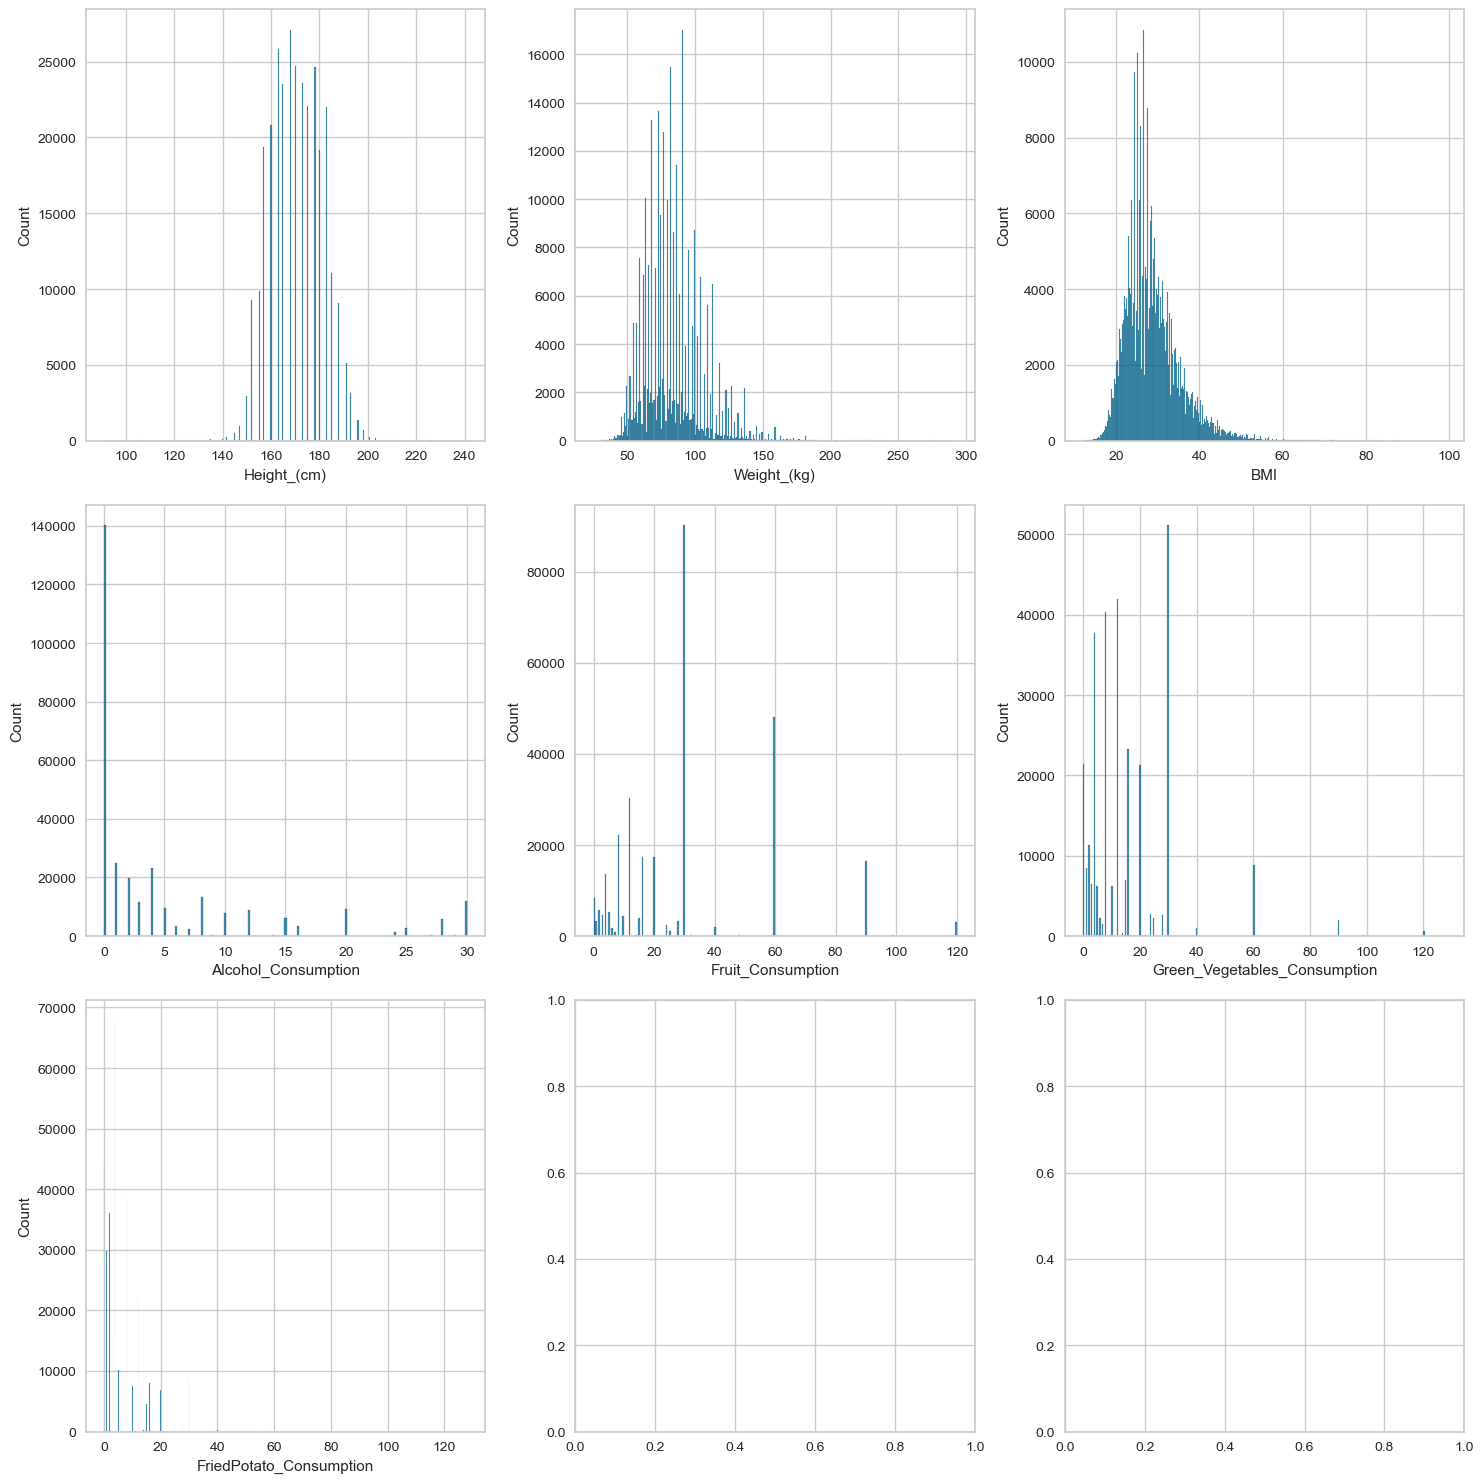

In [85]:
numerical_cols = ["Height_(cm)", "Weight_(kg)", "BMI", "Alcohol_Consumption", 
                  "Fruit_Consumption",'Green_Vegetables_Consumption', 'FriedPotato_Consumption']

fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for i, col in enumerate(numerical_cols):
    row = i // 3
    col = i % 3
    sns.histplot(cvd_cleaned_data[numerical_cols[i]], ax=axs[row, col])

plt.tight_layout()
plt.show()

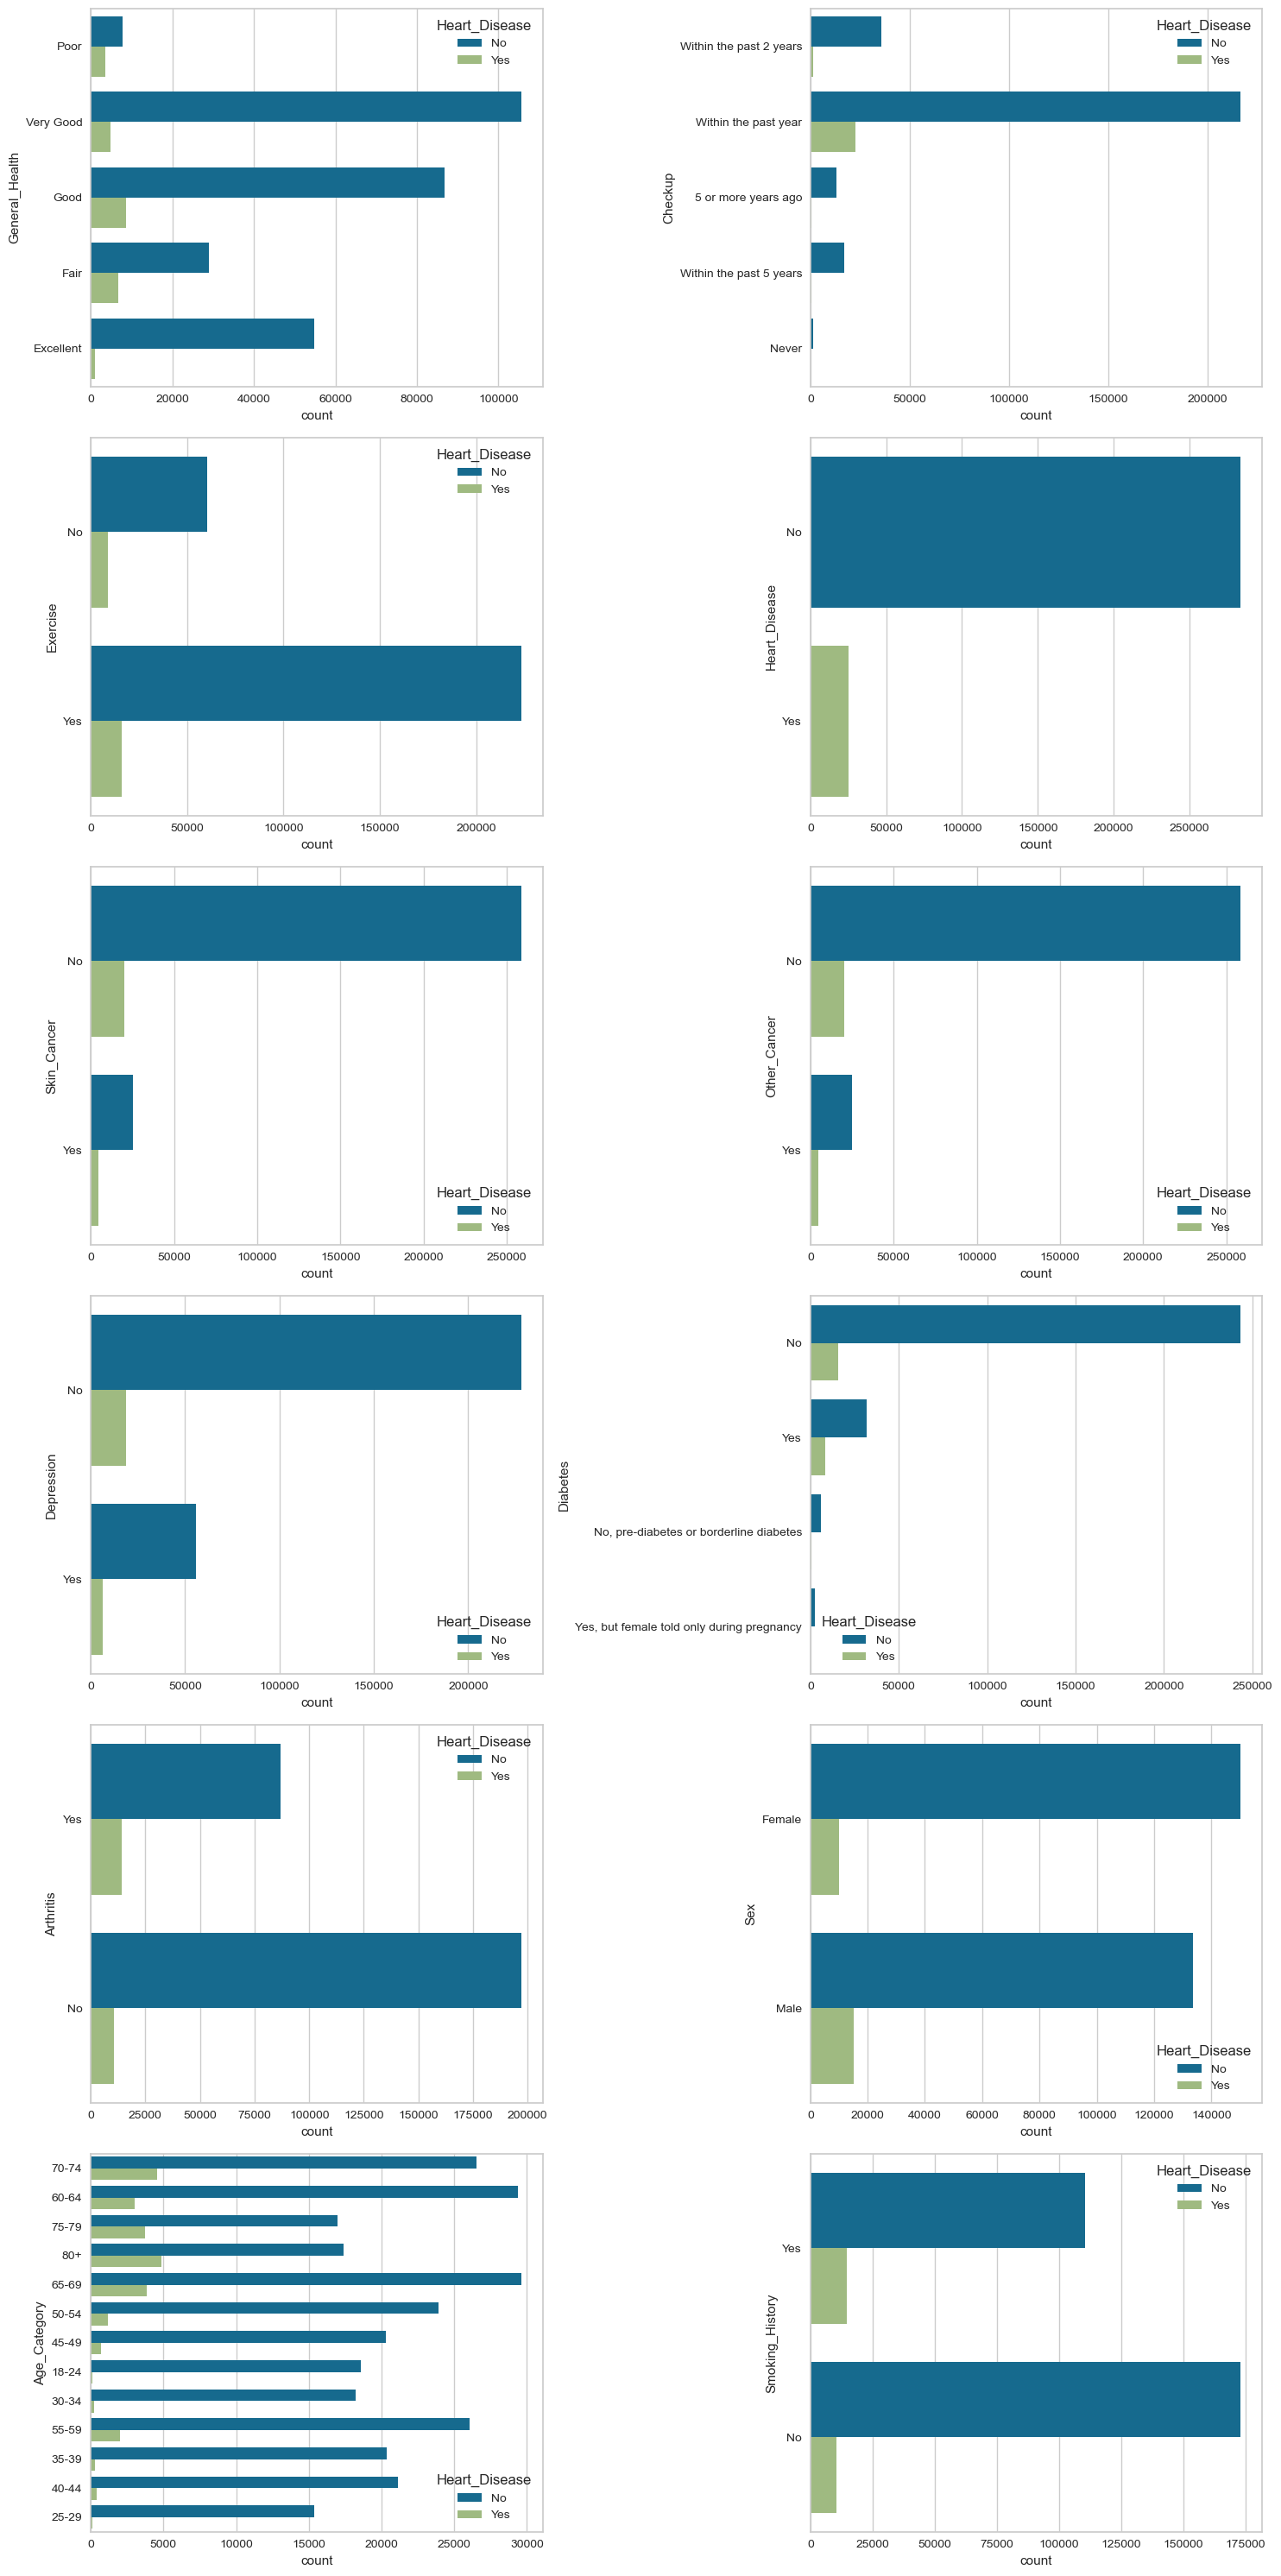

In [86]:
categorical_cols = ['General_Health', 'Checkup', 'Exercise', 'Heart_Disease', 'Skin_Cancer',
       'Other_Cancer', 'Depression', 'Diabetes', 'Arthritis', 'Sex',
       'Age_Category','Smoking_History']

# Plotting the distribution of categorical variables
fig, axs = plt.subplots(6, 2, figsize=(15, 30))

for i, col in enumerate(categorical_cols):
    row = i // 2
    col = i % 2
    sns.countplot(y=cvd_cleaned_data[categorical_cols[i]],hue=cvd_cleaned_data['Heart_Disease'], ax=axs[row, col])

plt.tight_layout()
plt.show()

In [87]:
#heart_attack_data

In [88]:
cvd_cleaned_data = pd.read_csv('CVD_cleaned.csv')

In [89]:
#Standardizing columns to lower case
cvd_cleaned_data.columns = cvd_cleaned_data.columns.str.lower().str.replace(' ', '_')

In [90]:
# printing of columns
cvd_cleaned_data.columns

Index(['general_health', 'checkup', 'exercise', 'heart_disease', 'skin_cancer',
       'other_cancer', 'depression', 'diabetes', 'arthritis', 'sex',
       'age_category', 'height_(cm)', 'weight_(kg)', 'bmi', 'smoking_history',
       'alcohol_consumption', 'fruit_consumption',
       'green_vegetables_consumption', 'friedpotato_consumption'],
      dtype='object')

In [91]:
import pickle
# creating of new columns in the  cvd_dataframe

def feature_engineering_cvd(df):
    df['obese'] = (df['bmi'] >= 28).astype(int)
    df['healthy_eating_ratio'] = df['fruit_consumption'] / (df['friedpotato_consumption'] + 1)
    return df
from sklearn.preprocessing import LabelEncoder

def preprocess_cvd_cleaned_data(df):
    # Standardize column names
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    
    # Remove duplicates
    df.drop_duplicates(inplace=True)
    
    # Fill missing values with median for numeric columns
    df.fillna(df.median(numeric_only=True), inplace=True)
    
    # Perform feature engineering
    df = feature_engineering_cvd(df)
    
    # Dictionary to store LabelEncoders for each categorical column
    label_encoders = {}
    categorical_cols = ['general_health', 'checkup', 'exercise', 'heart_disease', 'skin_cancer', 
                        'other_cancer', 'depression', 'diabetes', 'arthritis', 'sex', 'smoking_history']
    
    # Apply LabelEncoder to each categorical column
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le  # Store the encoder for later use
    
    return df, label_encoders

# Apply preprocessing
cvd_cleaned_data_clean, le_cvd_cleaned = preprocess_cvd_cleaned_data(cvd_cleaned_data)

In [92]:
le_cvd_cleaned

{'general_health': LabelEncoder(),
 'checkup': LabelEncoder(),
 'exercise': LabelEncoder(),
 'heart_disease': LabelEncoder(),
 'skin_cancer': LabelEncoder(),
 'other_cancer': LabelEncoder(),
 'depression': LabelEncoder(),
 'diabetes': LabelEncoder(),
 'arthritis': LabelEncoder(),
 'sex': LabelEncoder(),
 'smoking_history': LabelEncoder()}

In [14]:
# Remoning outlier
def remove_outliers(df, cols, threshold=1.5):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

numerical_cols_cvd = ['height_(cm)', 'weight_(kg)', 'bmi', 'alcohol_consumption', 'fruit_consumption', 
                      'green_vegetables_consumption', 'friedpotato_consumption']
cvd_cleaned_data_clean = remove_outliers(cvd_cleaned_data_clean, numerical_cols_cvd)

In [15]:

# Apply Preprocessing
#heart_attack_data_clean, le_heart_attack = preprocess_heart_attack_data(heart_attack_data)
#cvd_cleaned_data_clean, le_cvd = preprocess_cvd_cleaned_data(cvd_cleaned_data)


In [16]:
#heart_attack_data_clean.info()

In [17]:

# Outlier Removal for both datasets
#numerical_cols_heart_attack = [ 'bmi', 'cholesterol']
#heart_attack_data_clean = remove_outliers(heart_attack_data_clean, numerical_cols_heart_attack)

numerical_cols_cvd = ['height_(cm)', 'weight_(kg)', 'bmi', 'alcohol_consumption', 'fruit_consumption', 
                      'green_vegetables_consumption', 'friedpotato_consumption']
cvd_cleaned_data_clean = remove_outliers(cvd_cleaned_data_clean, numerical_cols_cvd)


In [18]:
def map_age_category_to_average(df, column):
    age_map = {
        '18-24': 21, '25-29': 27, '30-34': 32, '35-39': 37, 
        '40-44': 42, '45-49': 47, '50-54': 52, '55-59': 57,
        '60-64': 62, '65-69': 67, '70-74': 72, '75-79': 77, 
        '80+': 85  # Approximation for 80 and above
    }
    df[column] = df[column].map(age_map)
    return df
# Apply this function to the dataset
cvd_cleaned_data = map_age_category_to_average(cvd_cleaned_data, 'age_category')

# Preprocess the rest of the data as before
cvd_cleaned_data_clean = cvd_cleaned_data
print(cvd_cleaned_data.info())
cvd_cleaned_data.head(2)

<class 'pandas.core.frame.DataFrame'>
Index: 308774 entries, 0 to 308853
Data columns (total 21 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   general_health                308774 non-null  int32  
 1   checkup                       308774 non-null  int32  
 2   exercise                      308774 non-null  int32  
 3   heart_disease                 308774 non-null  int32  
 4   skin_cancer                   308774 non-null  int32  
 5   other_cancer                  308774 non-null  int32  
 6   depression                    308774 non-null  int32  
 7   diabetes                      308774 non-null  int32  
 8   arthritis                     308774 non-null  int32  
 9   sex                           308774 non-null  int32  
 10  age_category                  308774 non-null  int64  
 11  height_(cm)                   308774 non-null  float64
 12  weight_(kg)                   308774 non-null  fl

,general_health,checkup,exercise,heart_disease,skin_cancer,other_cancer,depression,diabetes,arthritis,sex,...,height_(cm),weight_(kg),bmi,smoking_history,alcohol_consumption,fruit_consumption,green_vegetables_consumption,friedpotato_consumption,obese,healthy_eating_ratio
0,3,2,0,0,0,0,0,0,1,0,...,150.0,32.66,14.54,1,0.0,30.0,16.0,12.0,0,2.307692
1,4,4,0,1,0,0,0,2,0,0,...,165.0,77.11,28.29,0,0.0,30.0,0.0,4.0,1,6.000000


In [19]:
# Normalization
scaler_cvd = StandardScaler()
columns_to_scale_cvd = ['bmi', 'height_(cm)', 'weight_(kg)', 'fruit_consumption', 'green_vegetables_consumption', 'friedpotato_consumption']
cvd_cleaned_data_clean[columns_to_scale_cvd] = scaler_cvd.fit_transform(cvd_cleaned_data_clean[columns_to_scale_cvd])


# Split Data into Train/Test Sets
X_cvd = cvd_cleaned_data_clean.drop(columns=['heart_disease'])
y_cvd = cvd_cleaned_data_clean['heart_disease']
X_train_cvd, X_test_cvd, y_train_cvd, y_test_cvd = train_test_split(X_cvd, y_cvd, test_size=0.3, random_state=42)


In [20]:
# Scaling Features
#scaler_heart_attack = StandardScaler()
#columns_to_scale_heart_attack = ['cholesterol', 'bmi', 'triglycerides', 'systolic_bp', 'diastolic_bp']
#heart_attack_data_clean[columns_to_scale_heart_attack] = scaler_heart_attack.fit_transform(heart_attack_data_clean[columns_to_scale_heart_attack])


In [21]:
cvd_cleaned_data

,general_health,checkup,exercise,heart_disease,skin_cancer,other_cancer,depression,diabetes,arthritis,sex,...,height_(cm),weight_(kg),bmi,smoking_history,alcohol_consumption,fruit_consumption,green_vegetables_consumption,friedpotato_consumption,obese,healthy_eating_ratio
0,3,2,0,0,0,0,0,0,1,0,...,-1.934170,-2.386099,-2.159627,1,0.0,0.006661,0.059656,0.664362,0,2.307692
1,4,4,0,1,0,0,0,2,0,0,...,-0.526833,-0.303608,-0.051636,0,0.0,0.006661,-1.012235,-0.267624,1,6.000000
2,4,4,1,0,0,0,0,2,0,0,...,-0.714478,0.227673,0.742501,0,4.0,-0.716876,-0.811255,1.130355,1,0.705882
3,3,4,1,1,0,0,0,2,0,1,...,0.880503,0.461456,0.015819,0,0.0,0.006661,0.997561,0.198369,1,3.333333
4,2,4,0,0,0,0,0,0,0,1,...,1.912549,0.227673,-0.652605,1,0.0,-0.877663,-0.744262,-0.733617,0,8.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308849,4,4,1,0,0,0,0,0,0,1,...,-0.245366,-0.090908,0.064878,0,4.0,0.006661,-0.476289,-0.733617,1,30.000000
308850,1,3,1,0,0,0,0,2,0,1,...,0.880503,-0.643740,-1.095666,0,8.0,-0.596287,3.007357,-0.267624,0,3.000000
308851,4,0,1,0,0,0,1,3,0,0,...,-1.277413,-1.047589,-0.603547,1,4.0,0.408626,-0.476289,-0.267624,0,8.000000
308852,4,4,1,0,0,0,0,0,0,1,...,1.161970,-0.197258,-0.750723,0,3.0,0.006661,-0.208317,-0.733617,0,30.000000


In [22]:
# Model Training and Evaluation
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    prediction_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    
    return {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=1),
        "recall": recall_score(y_test, y_pred, zero_division=1),
        "f1_score": f1_score(y_test, y_pred, zero_division=1)
    }

In [23]:


# Function to train a model
def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

# Initialize models
models = {
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Neural Network": MLPClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Naive Bayes": GaussianNB(),
    "Stochastic Gradient Descent": SGDClassifier(random_state=42),
}

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Define the PCA function
def perform_pca(X, n_components):
    pca = PCA(n_components=n_components, random_state=42)
    X_pca = pca.fit_transform(X)
    explained_variance = pca.explained_variance_ratio_
    return X_pca, explained_variance

# Call the function with X_train
X_train_pca, explained_variance_train = perform_pca(X_train_cvd, n_components=8)

# Apply PCA to the test data
X_test_pca = PCA(n_components=8, random_state=42).fit(X_train_cvd).transform(X_test_cvd)

print("Explained Variance by PCA (Top 8 Features):", explained_variance_train)


Explained Variance by PCA (Top 8 Features): [0.525876   0.35669169 0.10162061 0.003377   0.00316561 0.00180402
 0.00163188 0.00141144]


In [25]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_pca, y_train_cvd)

# Check the class distribution
print("Class distribution after SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

Class distribution after SMOTE:
heart_disease
1    198703
0    198703
Name: count, dtype: int64


In [26]:
len(y_train_cvd)

216141

In [51]:
X_test_cvd

,general_health,checkup,exercise,skin_cancer,other_cancer,depression,diabetes,arthritis,sex,age_category,height_(cm),weight_(kg),bmi,smoking_history,alcohol_consumption,fruit_consumption,green_vegetables_consumption,friedpotato_consumption,obese,healthy_eating_ratio
112130,0,3,1,0,0,0,0,0,0,57,-0.714478,-1.068672,-0.862638,1,0.0,-0.395304,-0.744262,1.130355,0,1.176471
95666,4,4,1,0,0,0,1,1,0,72,-1.465058,-0.473674,0.304039,1,0.0,0.006661,1.667493,-0.733617,1,30.000000
206006,0,4,1,0,0,0,0,0,0,52,-0.057721,-1.153470,-1.267372,0,0.0,0.006661,0.997561,-0.733617,0,30.000000
280617,4,4,1,0,0,0,0,0,0,85,-1.277413,-0.834889,-0.322992,0,0.0,1.212557,-0.744262,-0.384122,0,15.000000
148564,4,4,1,0,0,0,0,0,0,77,-0.995946,-0.197258,0.363829,0,2.0,0.006661,0.059656,0.081871,1,3.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34846,0,4,1,0,0,0,0,0,1,62,-0.526833,0.227673,0.586127,0,15.0,0.006661,0.327629,-0.384122,1,7.500000
254616,4,4,1,0,0,0,0,1,0,67,-1.746525,-1.259820,-0.646473,1,2.0,0.006661,-0.208317,-0.500620,0,10.000000
146276,4,4,1,0,0,0,0,0,0,37,-0.714478,-0.834889,-0.572885,1,0.0,0.006661,0.997561,0.198369,0,3.333333
293271,2,4,1,0,0,0,2,1,0,42,-0.995946,0.100241,0.744034,1,0.0,0.006661,3.007357,-0.267624,1,6.000000


In [50]:
X_test_pca[0]

array([-2.05770285, -9.1061318 , -5.35416723, -2.60547449, -1.24151598,
       -0.21748756, -0.19114495,  0.6061215 ])

In [28]:

from concurrent.futures import ThreadPoolExecutor, TimeoutError
# Time limit for training in seconds
time_limit = 300  
# Train and evaluate each model with a timeout
results = []


for model_name, model in models.items():
    print(model_name,'model training started')
    with ThreadPoolExecutor(max_workers=1) as executor:
        future = executor.submit(train_model, model, X_train_resampled, y_train_resampled)
        try:
            # Wait for the training to complete within the time limit
            trained_model = future.result(timeout=time_limit)
            metrics = evaluate_model(trained_model, X_test_pca, y_test_cvd)
            metrics["model"] = model_name
            results.append(metrics)
        except TimeoutError:
            print(f"{model_name} training exceeded the time limit and was skipped.")
        except Exception as e:
            print(f"{model_name} encountered an error: {e}")
    print(model_name,'model training ended')
# Convert results to DataFrame and display as a table
results_df = pd.DataFrame(results)
print(results_df)

Random Forest model training started
Random Forest model training ended
Logistic Regression model training started
Logistic Regression model training ended
Neural Network model training started
Neural Network training exceeded the time limit and was skipped.


C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network model training ended
Gradient Boosting model training started
Gradient Boosting training exceeded the time limit and was skipped.
Gradient Boosting model training ended
AdaBoost model training started
AdaBoost model training ended
Decision Tree model training started
Decision Tree model training ended
Naive Bayes model training started
Naive Bayes model training ended
Stochastic Gradient Descent model training started
Stochastic Gradient Descent model training ended
   accuracy  precision    recall  f1_score                        model
0  0.850075   0.245168  0.405814  0.305669                Random Forest
1  0.663910   0.164086  0.765167  0.270223          Logistic Regression
2  0.712565   0.184715  0.742466  0.295832                     AdaBoost
3  0.805177   0.173883  0.372096  0.237010                Decision Tree
4  0.620589   0.149145  0.779105  0.250363                  Naive Bayes
5  0.601503   0.147684  0.817470  0.250173  Stochastic Gradient Descent


In [30]:

from sklearn.model_selection import ParameterGrid
from tqdm import tqdm
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

# Create a parameter grid iterator
param_combinations = list(ParameterGrid(param_grid))
progress_bar = tqdm(param_combinations, desc="Grid Search Progress", unit="comb")

best_model = None
best_score = -float('inf')
best_params = None

# Perform grid search manually with a progress bar
for params in progress_bar:
    rf = RandomForestClassifier(random_state=42,n_jobs=-1, **params)
    rf.fit(X_train_resampled, y_train_resampled)
    y_pred = rf.predict(X_test_pca)
    f1 = f1_score(y_test_cvd, y_pred)

    if f1 > best_score:
        best_score = f1
        best_model = rf
        best_params = params

# Display results
print("Best Parameters:", best_params)
print("Best F1-Score:", best_score)



Grid Search Progress: 100%|███████████████████████████████████████████████████████| 36/36 [1:09:07<00:00, 115.20s/comb]

Best Parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best F1-Score: 0.3228429985855728


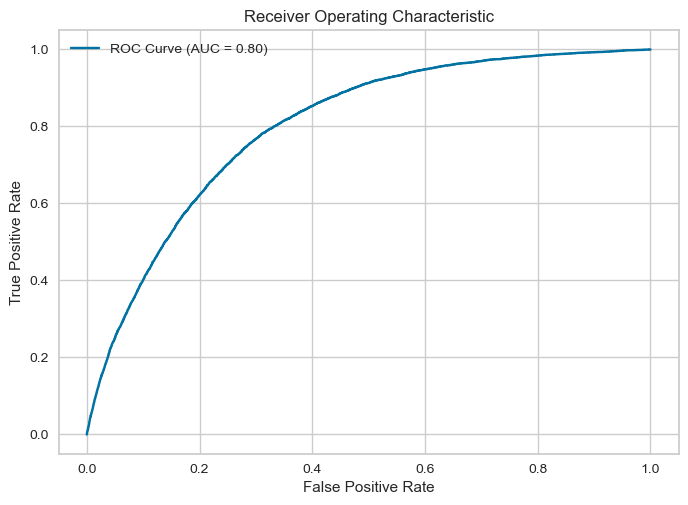

0.8009108204355204

In [31]:

def evaluate_roc(model, X_test, y_test):
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_pred_prob)
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic")
    plt.legend()
    plt.show()
    
    return auc_score
    
evaluate_roc(rf, X_test_pca, y_test_cvd)
 

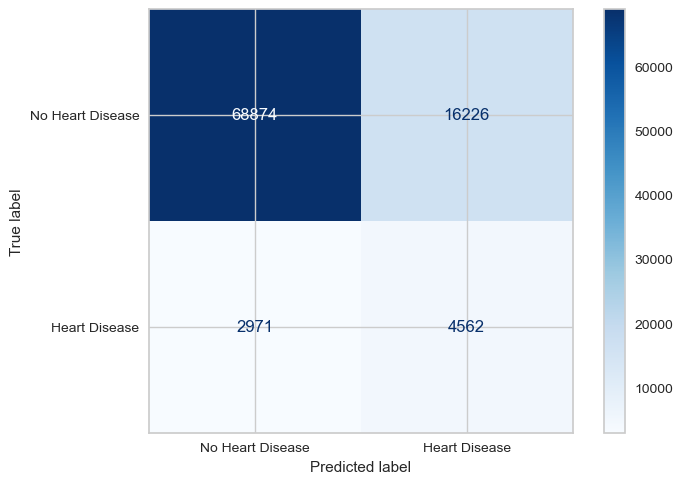

In [32]:


# Example: Random Forest Confusion Matrix
y_pred = rf.predict(X_test_pca)
cm = confusion_matrix(y_test_cvd, y_pred)
report =classification_report(y_test_cvd, y_pred)

ConfusionMatrixDisplay(cm, display_labels=['No Heart Disease', 'Heart Disease']).plot(cmap='Blues')
plt.show()


In [33]:
print(report)

              precision    recall  f1-score   support

           0       0.96      0.81      0.88     85100
           1       0.22      0.61      0.32      7533

    accuracy                           0.79     92633
   macro avg       0.59      0.71      0.60     92633
weighted avg       0.90      0.79      0.83     92633



In [34]:


# Define the RFE Function
def perform_rfe(model, X, y, n_features):
    rfe = RFE(estimator=model, n_features_to_select=n_features)
    rfe.fit(X, y)
    selected_features = X.columns[rfe.support_]  # Get selected feature names
    return selected_features, rfe.support_


In [35]:

# Initialize the Random Forest Model
rf_model = RandomForestClassifier(random_state=42)

# Perform RFE
selected_features_rf, support_ = perform_rfe(rf_model, X_train_cvd, y_train_cvd, n_features=10)


In [36]:

print("Selected Features by RFE (Random Forest):", selected_features_rf)


Selected Features by RFE (Random Forest): Index(['general_health', 'age_category', 'height_(cm)', 'weight_(kg)', 'bmi',
       'alcohol_consumption', 'fruit_consumption',
       'green_vegetables_consumption', 'friedpotato_consumption',
       'healthy_eating_ratio'],
      dtype='object')


In [37]:
print(selected_features_rf, support_)


Index(['general_health', 'age_category', 'height_(cm)', 'weight_(kg)', 'bmi',
       'alcohol_consumption', 'fruit_consumption',
       'green_vegetables_consumption', 'friedpotato_consumption',
       'healthy_eating_ratio'],
      dtype='object') [ True False False False False False False False False  True  True  True
  True False  True  True  True  True False  True]


In [38]:

print("PCA vs RFE Comparison:")
print("Top 10 Features (PCA Explained Variance):", explained_variance_train[:10])
print("Top 10 Features (RFE Selected):", selected_features_rf)

PCA vs RFE Comparison:
Top 10 Features (PCA Explained Variance): [0.525876   0.35669169 0.10162061 0.003377   0.00316561 0.00180402
 0.00163188 0.00141144]
Top 10 Features (RFE Selected): Index(['general_health', 'age_category', 'height_(cm)', 'weight_(kg)', 'bmi',
       'alcohol_consumption', 'fruit_consumption',
       'green_vegetables_consumption', 'friedpotato_consumption',
       'healthy_eating_ratio'],
      dtype='object')


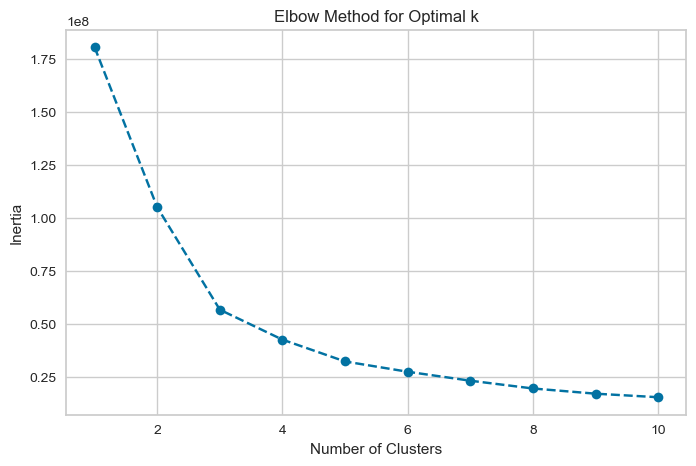

In [39]:

# Apply PCA
pca = PCA(n_components=2)  
X_cluster_pca = pca.fit_transform(X_cvd)

# Define the Elbow Method function
def optimal_clusters(data, max_k=10):
    
    inertia = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
       # kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)
    
    # Plot the elbow curve
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, max_k + 1), inertia, marker='o', linestyle='--')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    plt.show()

# Perform the Elbow Method
optimal_clusters(X_cluster_pca, max_k=10)


In [40]:
X_cluster_pca[:,0]

array([ 12.03110352,  13.62473803,   2.28845926, ..., -21.61935141,
        19.4297034 , -10.45928866])

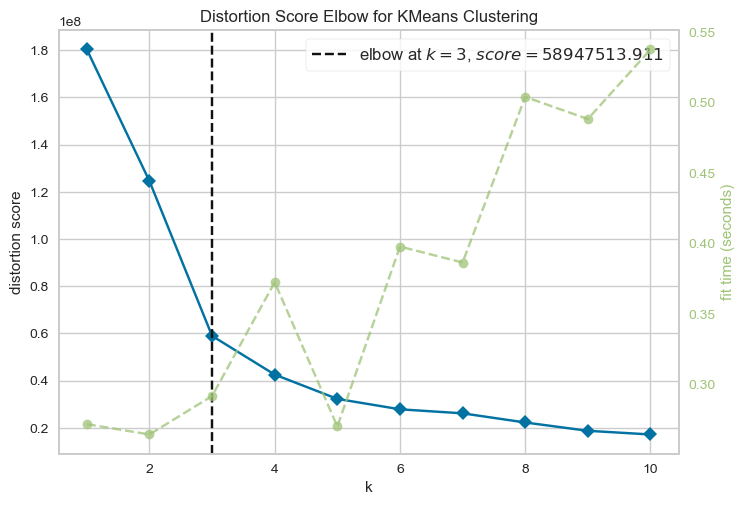

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [41]:

# Instantiate the KMeans model
model = KMeans(init='k-means++', max_iter=300,n_init='auto', random_state=1)

# Use the KElbowVisualizer to find the optimal number of clusters
visualizer = KElbowVisualizer(model, k=(1, 11))

# Fit the visualizer to the normalized dataset
visualizer.fit(X_cluster_pca)

# Visualize the elbow plot
visualizer.show()

In [42]:

X_sampled = resample(X_cluster_pca, n_samples=5000, random_state=42)
def compute_silhouette(n_clusters, X):
    clusterer = KMeans(n_clusters=n_clusters, random_state=10, n_init='auto')
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels, metric='euclidean')
    return silhouette_avg, n_clusters

range_n_clusters = range(2,11)
results = Parallel(n_jobs=-1)(delayed(compute_silhouette)(n, X_sampled) for n in range_n_clusters)

# Collect results
score = sorted(results, key=lambda x: x[1]) 
for silhouette_avg, n_clusters in score:
    print(f"For n_clusters = {n_clusters}, the average silhouette score is: {silhouette_avg}")


For n_clusters = 2, the average silhouette score is: 0.4484919148043955
For n_clusters = 3, the average silhouette score is: 0.5084280476035509
For n_clusters = 4, the average silhouette score is: 0.4868543167854772
For n_clusters = 5, the average silhouette score is: 0.44097611873841797
For n_clusters = 6, the average silhouette score is: 0.4467318383792139
For n_clusters = 7, the average silhouette score is: 0.4126974843995631
For n_clusters = 8, the average silhouette score is: 0.42530621708886013
For n_clusters = 9, the average silhouette score is: 0.40166017532892245
For n_clusters = 10, the average silhouette score is: 0.40617972250420564


In [43]:
Max = max(score, key=lambda x: x)
print(score, '\n\nMax:',Max, '\nBest K = \n', Max[1] )
bestNumberClusters =  Max[1]

[(0.4484919148043955, 2), (0.5084280476035509, 3), (0.4868543167854772, 4), (0.44097611873841797, 5), (0.4467318383792139, 6), (0.4126974843995631, 7), (0.42530621708886013, 8), (0.40166017532892245, 9), (0.40617972250420564, 10)] 

Max: (0.5084280476035509, 3) 
Best K = 
 3


In [44]:
clusterer = KMeans(n_clusters =  Max[1],n_init='auto', random_state=10)
cluster_labels = clusterer.fit_predict(X_sampled)
silhouette_avg = silhouette_score(X_sampled, cluster_labels)
print(score, '\n\nsilhouette_avg:',silhouette_avg )

[(0.4484919148043955, 2), (0.5084280476035509, 3), (0.4868543167854772, 4), (0.44097611873841797, 5), (0.4467318383792139, 6), (0.4126974843995631, 7), (0.42530621708886013, 8), (0.40166017532892245, 9), (0.40617972250420564, 10)] 

silhouette_avg: 0.5084280476035509


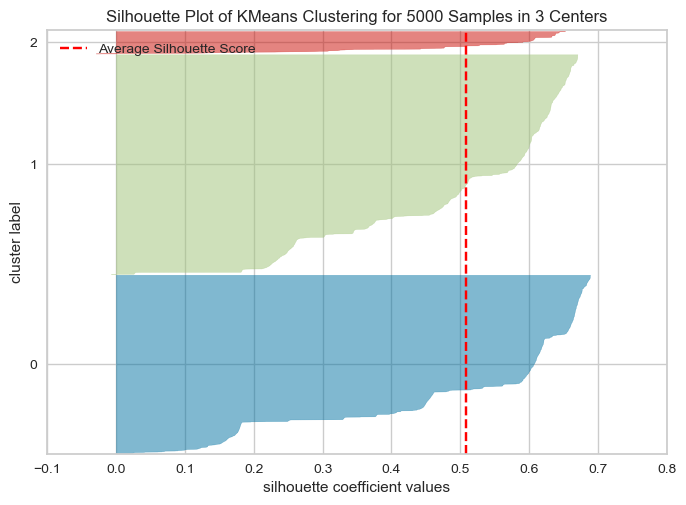

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 5000 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [45]:

from yellowbrick.cluster import SilhouetteVisualizer
visualizer = SilhouetteVisualizer(clusterer,colors =  'yellowbrick')
# #Fit the data to the visualizer
visualizer.fit(X_sampled)       
#Render the figure
visualizer.show()

In [46]:
optimal_k = 3 
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(X_cluster_pca)
cvd_cleaned_data_clean['Cluster'] = clusters


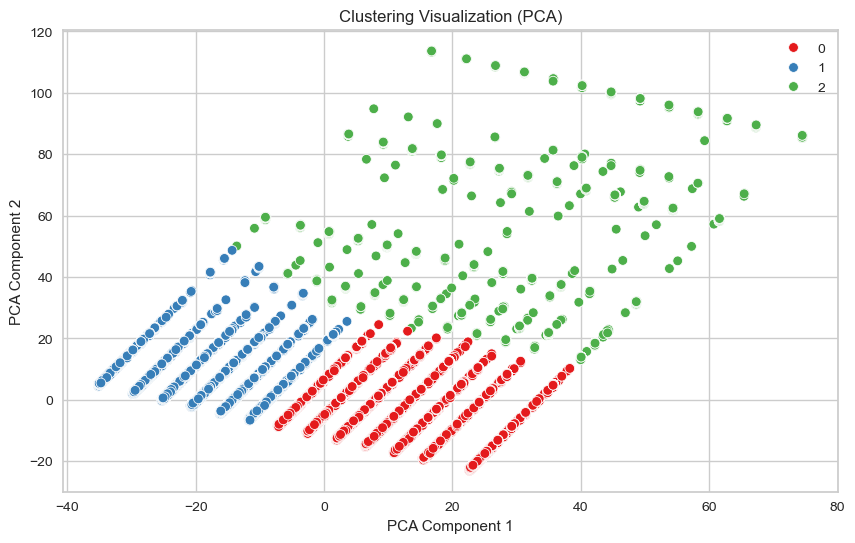

In [47]:
# Visualize Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_cluster_pca[:, 0], y=X_cluster_pca[:, 1], hue=clusters, palette='Set1')
plt.title('Clustering Visualization (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [93]:
import pickle

# Define objects to save
objects_to_save = {
    "cvd_cleaned_data_clean": cvd_cleaned_data_clean,
    "best_model": best_model,
    "label_encoder": le_cvd_cleaned,
    "scaler": scaler_cvd,
    "pca": pca,
    "selected_features_rfe": selected_features_rf,
  "explained_variance_pca": explained_variance_train,
    "kmeans_clusterer": kmeans,
    "cluster_labels": clusters
}

# Save each object as a separate file
for obj_name, obj in objects_to_save.items():
    with open(f"{obj_name}.pkl", "wb") as f:
        pickle.dump(obj, f)
        print(f"Saved {obj_name}.pkl")


Saved cvd_cleaned_data_clean.pkl
Saved best_model.pkl
Saved label_encoder.pkl
Saved scaler.pkl
Saved pca.pkl
Saved selected_features_rfe.pkl
Saved explained_variance_pca.pkl
Saved kmeans_clusterer.pkl
Saved cluster_labels.pkl


array(['No', 'Yes'], dtype=object)

In [101]:
import pickle
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Define a function to load pickle files
def load_pickle(file_name):
    with open(file_name, "rb") as f:
        return pickle.load(f)

# Load objects
cvd_cleaned_data_clean = load_pickle("cvd_cleaned_data_clean.pkl")
best_model = load_pickle("best_model.pkl")
label_encoders = load_pickle("label_encoder.pkl")
scaler = load_pickle("scaler.pkl")
pca = load_pickle("pca.pkl")
selected_features_rfe = load_pickle("selected_features_rfe.pkl")
explained_variance_pca = load_pickle("explained_variance_pca.pkl")
kmeans_clusterer = load_pickle("kmeans_clusterer.pkl")
cluster_labels = load_pickle("cluster_labels.pkl")

# Sample data point (replace with your own values)
new_sample = pd.DataFrame({
    "height_(cm)": [170],
    "weight_(kg)": [70],
    "bmi": [24.22],
    "alcohol_consumption": [2],
    "fruit_consumption": [5],
    "green_vegetables_consumption": [3],
    "friedpotato_consumption": [1],
    "general_health": ["Good"],
    "checkup": ["Never"],
    "exercise": ["Yes"],
    "skin_cancer": ["No"],
    "other_cancer": ["No"],
    "depression": ["No"],
    "diabetes": ["No"],
    "arthritis": ["No"],
    "sex": ["Male"],
    "smoking_history": ["No"],
    "age_category": ["30-34"]
})

# Apply the same feature engineering
new_sample["obese"] = (new_sample["bmi"] >= 28).astype(int)
new_sample["healthy_eating_ratio"] = new_sample["fruit_consumption"] / (new_sample["friedpotato_consumption"] + 1)

# Map age_category to numerical
age_map = {
    "18-24": 21, "25-29": 27, "30-34": 32, "35-39": 37, 
    "40-44": 42, "45-49": 47, "50-54": 52, "55-59": 57,
    "60-64": 62, "65-69": 67, "70-74": 72, "75-79": 77, 
    "80+": 85
}
new_sample["age_category"] = new_sample["age_category"].map(age_map)
# Encode categorical variables using saved label encoders
categorical_cols = [
    "general_health", "checkup", "exercise", "skin_cancer", "other_cancer", 
    "depression", "diabetes", "arthritis", "sex", "smoking_history"
]

for col in categorical_cols:
    # Use the corresponding LabelEncoder for each column
    if col in label_encoders:
        try:
            # Ensure the input is a 1D array-like structure
            new_sample[col] = label_encoders[col].transform(new_sample[col].values)
        except ValueError as e:
            raise ValueError(
                f"Error transforming column '{col}': {e}. "
                "Ensure all values in the column match the categories seen during training."
            )
    else:
        raise ValueError(f"No LabelEncoder found for column: {col}")
        # Scale numerical features
columns_to_scale = ['bmi', 'height_(cm)', 'weight_(kg)', 'fruit_consumption', 
                    'green_vegetables_consumption', 'friedpotato_consumption']
new_sample[columns_to_scale] = scaler.transform(new_sample[columns_to_scale])

# Apply PCA
new_sample_pca = PCA(n_components=8, random_state=42).fit(X_train_cvd).transform(new_sample[X_train_cvd.columns])

# Predict heart disease using the trained model
heart_disease_prediction = best_model.predict(new_sample_pca)
print("Heart Disease Prediction:", "Yes" if heart_disease_prediction[0] == 1 else "No")



In [107]:
new_sample[X_train_cvd.columns]

,general_health,checkup,exercise,skin_cancer,other_cancer,depression,diabetes,arthritis,sex,age_category,height_(cm),weight_(kg),bmi,smoking_history,alcohol_consumption,fruit_consumption,green_vegetables_consumption,friedpotato_consumption,obese,healthy_eating_ratio
0,2,1,1,0,0,0,0,0,1,32,-16.012946,-3.946056,-4.492306,0,2,-1.239361,-1.066584,-0.80551,0,2.5


In [106]:
X_train_cvd.columns

Index(['general_health', 'checkup', 'exercise', 'skin_cancer', 'other_cancer',
       'depression', 'diabetes', 'arthritis', 'sex', 'age_category',
       'height_(cm)', 'weight_(kg)', 'bmi', 'smoking_history',
       'alcohol_consumption', 'fruit_consumption',
       'green_vegetables_consumption', 'friedpotato_consumption', 'obese',
       'healthy_eating_ratio'],
      dtype='object')

Heart Disease Prediction: No


In [111]:
X_train_cvd.to_csv('train.csv', index=False)

array(['No', 'Yes'], dtype=object)

In [117]:
categorical_cols = [
    "general_health", "checkup", "exercise", "skin_cancer", "other_cancer", 
    "depression", "diabetes", "arthritis", "sex", "smoking_history"
]

for col in categorical_cols:
    print(col,label_encoders[col].classes_)

general_health ['Excellent' 'Fair' 'Good' 'Poor' 'Very Good']
checkup ['5 or more years ago' 'Never' 'Within the past 2 years'
 'Within the past 5 years' 'Within the past year']
exercise ['No' 'Yes']
skin_cancer ['No' 'Yes']
other_cancer ['No' 'Yes']
depression ['No' 'Yes']
diabetes ['No' 'No, pre-diabetes or borderline diabetes' 'Yes'
 'Yes, but female told only during pregnancy']
arthritis ['No' 'Yes']
sex ['Female' 'Male']
smoking_history ['No' 'Yes']


In [121]:
X_train_cvd = pd.read_csv('train.csv')

In [122]:
X_train_cvd

,general_health,checkup,exercise,skin_cancer,other_cancer,depression,diabetes,arthritis,sex,age_category,height_(cm),weight_(kg),bmi,smoking_history,alcohol_consumption,fruit_consumption,green_vegetables_consumption,friedpotato_consumption,obese,healthy_eating_ratio
0,3,4,1,1,1,1,1,1,0,67,-2.215637,-1.153470,-0.223342,1,1.0,-0.556090,-0.208317,2.528333,0,0.551724
1,2,4,1,0,1,0,0,0,0,67,-0.995946,-0.771173,-0.368985,0,0.0,0.006661,-1.012235,-0.733617,0,30.000000
2,4,4,1,0,0,0,0,0,1,52,0.692858,0.758954,0.451215,1,12.0,0.006661,-0.208317,-0.500620,1,10.000000
3,4,4,1,1,0,0,0,1,1,57,1.161970,0.801588,0.227385,1,8.0,1.212557,-0.476289,0.198369,1,6.666667
4,2,4,1,1,1,0,0,1,1,85,0.411391,-0.218341,-0.448705,0,0.0,-0.395304,-0.744262,-0.267624,0,4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216136,2,4,1,0,0,0,0,1,0,72,-0.057721,-0.303608,-0.306128,1,25.0,1.212557,0.997561,0.081871,0,7.500000
216137,1,4,1,0,0,1,0,0,0,47,-0.245366,0.334023,0.560064,0,4.0,-0.877663,-0.476289,1.130355,1,0.470588
216138,0,2,1,1,0,0,0,0,1,52,0.411391,0.440373,0.251914,0,2.0,-0.797270,-0.208317,0.198369,1,1.111111
216139,2,4,1,1,0,0,0,0,1,42,2.569306,1.927867,0.483410,1,4.0,2.418452,0.997561,-0.267624,1,18.000000


In [126]:
X_train_cvd.sample(frac= 0.1).to_csv('2train.csv', index= False)